In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
states = ShapelyFeature(Reader('/glade/work/mazrooei/DATA/useful_shapefiles/states.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
proj = ccrs.Orthographic(central_longitude=-100, central_latitude=35)
ncproj = ccrs.PlateCarree()
# Define the projection of NWM
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0))
extent_conus = [-122, -73, 22, 50]


In [4]:
%%time
list_basins = pd.read_csv('/glade/u/home/mazrooei/work/USGS/usgs_ealstm/ealstm_regional_modeling/data/basin_list.txt', dtype=str, names=['site_no']).site_no.to_list()
data_LSTM = pd.read_pickle('/glade/u/home/mazrooei/work/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_2903_2008_seed588170/ealstm_seed588170.p')

usgs_meta = pd.read_csv("/glade/p/cisl/nwc/nwm_verification_obs/streamflow_usgs/obsStrMeta.csv", dtype={'site_no': str}, index_col=0).set_index('site_no')
usgs_meta = usgs_meta.sort_index()
usgs_short_columns = ['station_nm', 'dec_lat_va', 'dec_long_va']
usgs_short = usgs_meta[usgs_short_columns]



CPU times: user 586 ms, sys: 58.2 ms, total: 644 ms
Wall time: 713 ms


In [5]:
def my_verif(obs, sim):
    # sim = df.qsim
    # obs = df.qobs

    sim_log = np.log(sim+0.0001)
    sim_mean = np.mean(sim)
    sim_std = np.std(sim)
    
    obs_log = np.log(obs+0.0001)
    obs_mean = np.mean(obs)
    obs_std = np.std(obs)

    Bias = sim_mean - obs_mean
    Bias_perc = 100*Bias / obs_mean
    Err = sim-obs
    MSE = np.mean(Err**2)
    RMSE = np.sqrt(MSE)
    RRMSE = RMSE / obs_mean
    
    corr_pear = obs.corr(sim) 
    corr_rank = obs.corr(sim, method='spearman')
    
    KGE_alpha = sim_std  / obs_std
    KGE_beta  = sim_mean / obs_mean
    NSE_A = corr_pear**2
    NSE_B = (corr_pear - KGE_alpha)**2
    NSE_C = (Bias / obs_std)**2

    NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
    KGE = 1-( np.sqrt( (corr_pear-1)**2 + (KGE_alpha-1)**2 + (KGE_beta-1)**2 ) )
    LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
    WtNSE = (0.5*NSE) + (0.5*LogNSE)
    
    out_df = pd.DataFrame({'mean_obs':obs_mean,
                           'mean_sim':sim_mean, 
                           'std_obs':obs_std,
                           'std_sim':sim_std, 
                           'Bias': Bias,
                           'Bias_perc': Bias_perc,
                           'corr_pear': corr_pear,
                           'corr_rank': corr_rank,
                           'NSE': NSE,
                           'KGE': KGE,
                           'LogNSE': LogNSE,
                           'WtNSE': WtNSE,
                           'MSE': MSE,
                           'RMSE': RMSE,
                           'RRMSE': RRMSE,
                           'NSE_A':NSE_A, 
                           'NSE_B':NSE_B, 
                           'NSE_C':NSE_C, 
                           'KGE_alpha':KGE_alpha, 
                           'KGE_beta':KGE_beta
                           }, index=[0])
    return out_df.round(4)


In [6]:
## Compute verif metrics for all sites
Metrics = pd.DataFrame()
for s in tqdm(list_basins):
    df = data_LSTM[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics = Metrics.append(verif)

Metrics = usgs_short.loc[list_basins].join(Metrics)
Metrics = Metrics.rename(columns={'Bias':'Bias [mm/day]'})
display(Metrics)

100%|██████████| 1291/1291 [00:19<00:00, 66.52it/s]


,station_nm,dec_lat_va,dec_long_va,mean_obs,mean_sim,std_obs,std_sim,Bias [mm/day],Bias_perc,corr_pear,...,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,,
01013500,"Fish River near Fort Kent, Maine",47.237500,-68.582778,1.7943,1.8077,2.1048,2.0020,0.0134,0.7493,0.9744,...,0.8601,0.9045,0.2262,0.4756,0.2651,0.9495,0.0005,0.0000,0.9512,1.0075
01021480,"Old Stream near Wesley, Maine",44.936944,-67.736111,2.1224,2.1473,2.6471,2.5737,0.0249,1.1743,0.9374,...,0.8616,0.8695,0.8588,0.9267,0.4366,0.8787,0.0012,0.0001,0.9723,1.0117
01027200,"North Branch Penobscot River nr Pittston Farm, ME",45.935278,-69.993611,2.1017,2.0772,3.3511,3.0579,-0.0246,-1.1686,0.9237,...,0.8061,0.8296,1.6503,1.2846,0.6112,0.8532,0.0001,0.0001,0.9125,0.9883
01029200,"Seboeis River near Shin Pond, Maine",46.143056,-68.633611,1.8687,1.8304,2.4482,2.3255,-0.0383,-2.0503,0.9685,...,0.8542,0.8958,0.3747,0.6122,0.3276,0.9381,0.0003,0.0002,0.9499,0.9795
01030500,"Mattawamkeag River near Mattawamkeag, Maine",45.501111,-68.305833,2.0996,2.1378,2.5196,2.3212,0.0382,1.8175,0.9584,...,0.8085,0.8627,0.5275,0.7263,0.3459,0.9185,0.0014,0.0002,0.9212,1.0182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14318000,"LITTLE RIVER AT PEEL, OR",43.252618,-123.026172,2.3392,2.2353,3.7498,3.5257,-0.1039,-4.4415,0.9454,...,0.9512,0.9221,1.5049,1.2268,0.5244,0.8938,0.0000,0.0008,0.9402,0.9556
14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.891499,-124.070652,4.2222,4.3878,7.5992,7.1897,0.1656,3.9232,0.9393,...,0.9284,0.9051,6.8247,2.6124,0.6187,0.8823,0.0000,0.0005,0.9461,1.0392
14362250,"STAR GULCH NEAR RUCH, OR",42.154014,-123.075323,0.2731,0.3066,0.7219,0.6701,0.0334,12.2364,0.9404,...,0.2943,0.5881,0.0615,0.2480,0.9079,0.8843,0.0001,0.0021,0.9282,1.1224


(-0.2, 0.2)

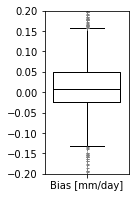

In [113]:
flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                  linestyle='none', markeredgecolor='grey')

plt.figure(figsize=(1.5,3))
plt.boxplot(Metrics['Bias [mm/day]'], widths=.8, flierprops=flierprops, labels=['Bias [mm/day]'], medianprops=dict(color='k'))
plt.ylim((-.20,.20))


(-20.0, 20.0)

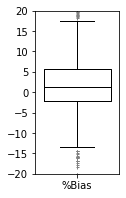

In [114]:
plt.figure(figsize=(1.5,3))
plt.boxplot(Metrics['Bias_perc'], labels=['%Bias'], widths=.8, medianprops=dict(color='k'), flierprops=flierprops)
plt.ylim((-20,20))

(0.0, 1.0)

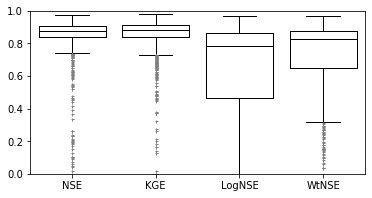

In [67]:


plt.figure(figsize=(6,3))
Metrics.boxplot(column=['NSE', 'KGE', 'LogNSE', 'WtNSE'], widths=.8, grid=False, color='k', flierprops=flierprops) #showfliers=Fals
plt.ylim((0,1))

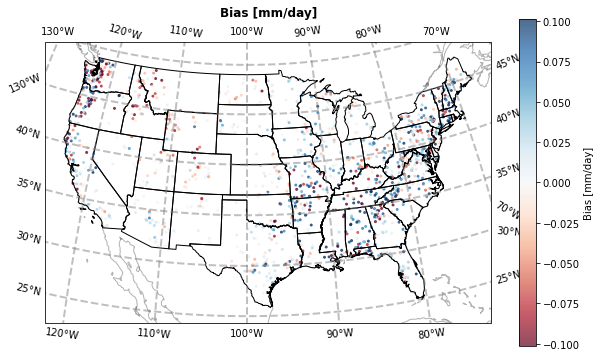

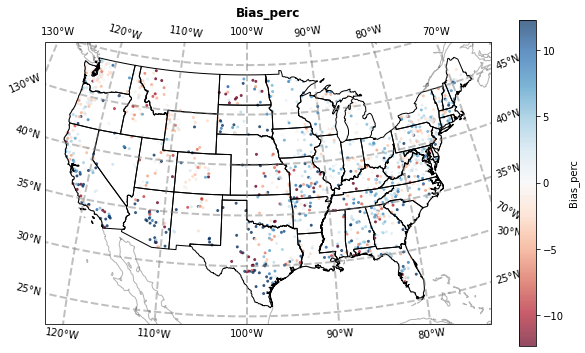

In [122]:
for varname in ['Bias [mm/day]', 'Bias_perc']:
    var = Metrics[varname]
    cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    cmin = -1 * cmax
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='RdBu', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

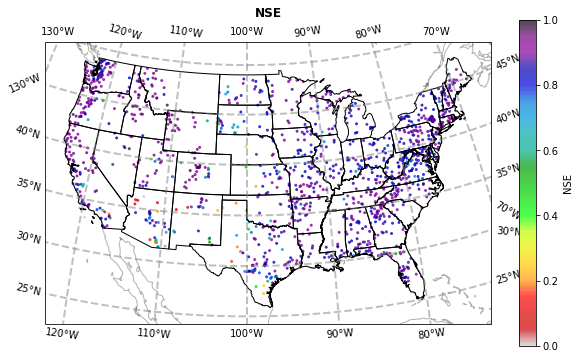

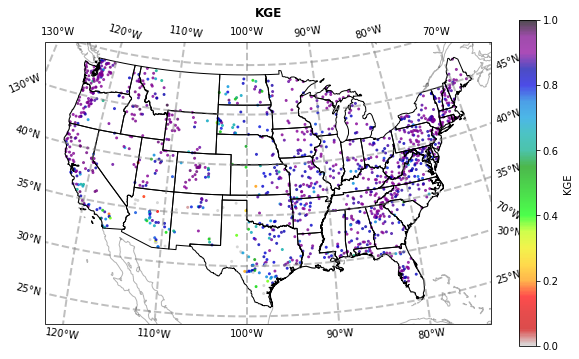

In [123]:
for varname in ['NSE', 'KGE']:
    var = Metrics[varname]
    cmin = 0
    cmax = 1
    fig = plt.figure(figsize=(10,6))
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(wspace=0.15, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    Metrics.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=varname, 
                         s=4, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r', alpha=.7)
    # sc1 = ax1.scatter(Metrics.dec_long_va, Metrics.dec_lat_va, transform=ccrs.PlateCarree(), s=7, c=var, vmin=cmin, vmax=cmax, cmap='nipy_spectral_r')
    # plt.colorbar(sc1, orientation='vertical',ticklocation='auto')
    ax1.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.set_title(varname, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())



### Hydrograph, single basin

In [126]:
Metrics.NSE.idxmin()

'07227420'

            qobs      qsim  err  %err
2005-10-01   NaN  0.000000  NaN   NaN
2005-10-02   NaN  0.003591  NaN   NaN
2005-10-03   NaN  0.003876  NaN   NaN
2005-10-04   NaN  0.003590  NaN   NaN
2005-10-05   NaN  0.005730  NaN   NaN
...          ...       ...  ...   ...
2021-09-26   NaN  0.001429  NaN   NaN
2021-09-27   NaN  0.001249  NaN   NaN
2021-09-28   NaN  0.004713  NaN   NaN
2021-09-29   NaN  0.003935  NaN   NaN
2021-09-30   NaN  0.001164  NaN   NaN

[5844 rows x 4 columns]


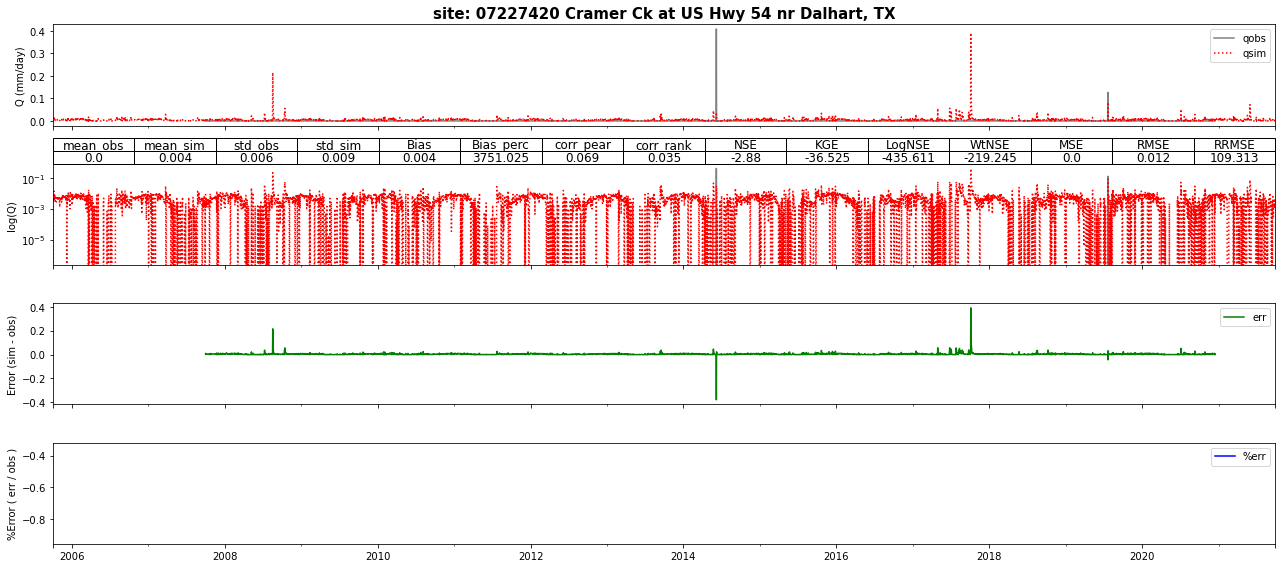

In [14]:
s = '07227420'
df = data_LSTM[s]
df['err'] = df.qsim - df.qobs
df['%err'] = df.err / df.qobs
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
print(df)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18,8))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
df.plot.line(ax=axes[2], y=['err'], color={"err":"green"}, style=['-'], legend=True).legend(loc='upper right')
df.plot.line(ax=axes[3], y=['%err'], color={"%err":"blue"}, style=['-'], legend=True).legend(loc='upper right')
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[2].set_ylabel('Error (sim - obs)')
axes[3].set_ylabel('%Error ( err / obs )')
axes[1].set_xlabel('Date')
axes[0].set_title('site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

<AxesSubplot:>

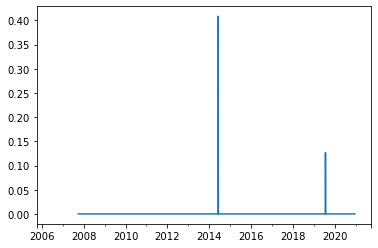

In [27]:
df.qobs.plot()

In [127]:
verif.iloc[:, :10]

,mean_obs,mean_sim,std_obs,std_sim,Bias,Bias_perc,corr_pear,corr_rank,NSE,KGE
0,2.701746,2.461445,5.144389,4.890418,-0.2403,-8.894261,0.94638,0.980782,0.893435,0.885008
